# Регрессия для предсказания `outcome`

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    confusion_matrix,
    f1_score,
)

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LogisticRegression, LinearRegression, ElasticNet


pd.set_option("display.max_columns", None)
sns.set_theme(style="whitegrid")

Для основных распределений датасета, см. `l1.ipynb`

In [36]:
path = "dataset/horse.csv"
df = pd.read_csv(path)
print(df.shape)
df.head()

(299, 28)


,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,pain,peristalsis,abdominal_distention,nasogastric_tube,nasogastric_reflux,nasogastric_reflux_ph,rectal_exam_feces,abdomen,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,outcome,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data
0,no,adult,530101,38.5,66.0,28.0,cool,reduced,NaN,more_3_sec,extreme_pain,absent,severe,NaN,NaN,NaN,decreased,distend_large,45.0,8.4,NaN,NaN,died,no,11300,0,0,no
1,yes,adult,534817,39.2,88.0,20.0,NaN,NaN,pale_cyanotic,less_3_sec,mild_pain,absent,slight,NaN,NaN,NaN,absent,other,50.0,85.0,cloudy,2.0,euthanized,no,2208,0,0,no
2,no,adult,530334,38.3,40.0,24.0,normal,normal,pale_pink,less_3_sec,mild_pain,hypomotile,none,NaN,NaN,NaN,normal,normal,33.0,6.7,NaN,NaN,lived,no,0,0,0,yes
3,yes,young,5290409,39.1,164.0,84.0,cold,normal,dark_cyanotic,more_3_sec,depressed,absent,severe,none,less_1_liter,5.0,decreased,NaN,48.0,7.2,serosanguious,5.3,died,yes,2208,0,0,yes
4,no,adult,530255,37.3,104.0,35.0,NaN,NaN,dark_cyanotic,more_3_sec,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,74.0,7.4,NaN,NaN,died,no,4300,0,0,no


## Бейзлайн: Логистическая регрессия без подбора гиперпараметров

### Бейзлайн датасет

In [37]:
X = df.drop(columns=["outcome"])
y = df["outcome"]


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

Тренериуем бейзлайн

In [38]:
cat_cols = X.select_dtypes(include=["object"]).columns.tolist()
num_cols = [c for c in X.columns if c not in cat_cols]

numeric_pipe = Pipeline(
    [("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)

categorical_pipe = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(handle_unknown="ignore")),
    ]
)

preprocess = ColumnTransformer(
    [("num", numeric_pipe, num_cols), ("cat", categorical_pipe, cat_cols)]
)

logreg_base = LogisticRegression(random_state=42, max_iter=1000)
model_base = Pipeline([("preprocess", preprocess), ("clf", logreg_base)])
model_base.fit(X_train, y_train)


,steps,"[('preprocess', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


### Оценка бейзлайна на тестовой выборке

In [39]:
y_pred = model_base.predict(X_test)
y_pred_proba = model_base.predict_proba(X_test)[:, 1]

acc_base = accuracy_score(y_test, y_pred)
f1_base = f1_score(y_test, y_pred, average="macro")

print("Accuracy:", acc_base)
print("\nClassification report:\n", classification_report(y_test, y_pred))


Accuracy: 0.6

Classification report:
               precision    recall  f1-score   support

        died       0.59      0.67      0.62        15
  euthanized       0.22      0.22      0.22         9
       lived       0.71      0.67      0.69        36

    accuracy                           0.60        60
   macro avg       0.51      0.52      0.51        60
weighted avg       0.60      0.60      0.60        60



### Тепловая карта confusion matrix

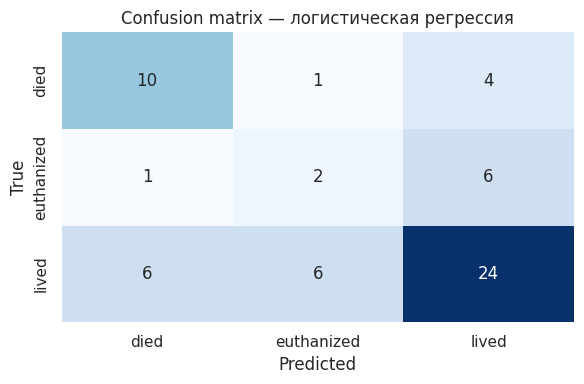

In [40]:
cm = confusion_matrix(y_test, y_pred, labels=model_base.classes_)
fig, axes = plt.subplots(1, 1, figsize=(6, 4))

sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    cbar=False,
    xticklabels=model_base.classes_,
    yticklabels=model_base.classes_,
    ax=axes,
)
axes.set_xlabel("Predicted")
axes.set_ylabel("True")
axes.set_title("Confusion matrix — логистическая регрессия")

plt.tight_layout()
plt.show()


## Улучшение бейзлайна для логистической регрессии
1. Сделать gridsearch с подбором параметров логистической регрессии
2. Использовать class_weight для учета дисбаланса классов
3. Попробовать разные регуляризации и значения C
4. Использовать метрику f1_macro для многоклассовой классификации

### Подготовка улучшенного датасета


In [41]:
missing_thresh = 0.7
missing_pct = df.isna().mean()
high_na_cols = missing_pct[missing_pct > missing_thresh].index.tolist()

print(f"Колонки, удалённые по порогу пропусков ({missing_thresh * 100}%):")
for col in high_na_cols:
    print(f"  - {col}: {missing_pct[col] * 100:.1f}% пропусков")

df_imp = df.drop(columns=high_na_cols)

X_imp = df_imp.drop(columns=["outcome"])
y_imp = df_imp["outcome"]

cat_cols_imp = X_imp.select_dtypes(include=["object"]).columns.tolist()
num_cols_imp = [c for c in X_imp.columns if c not in cat_cols_imp]

print(
    f"\nОсталось признаков: {X_imp.shape[1]} ({len(num_cols_imp)} числовых, {len(cat_cols_imp)} категориальных)"
)

X_train_imp, X_test_imp, y_train_imp, y_test_imp = train_test_split(
    X_imp, y_imp, test_size=0.2, random_state=42, stratify=y_imp
)


Колонки, удалённые по порогу пропусков (70.0%):
  - nasogastric_reflux_ph: 82.3% пропусков

Осталось признаков: 26 (10 числовых, 16 категориальных)


### Подбор гиперпараметров для логистической регрессии


In [42]:
numeric_pipe_imp = Pipeline(
    [("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)

categorical_pipe_imp = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
    ]
)

preprocess_imp = ColumnTransformer(
    [
        ("num", numeric_pipe_imp, num_cols_imp),
        ("cat", categorical_pipe_imp, cat_cols_imp),
    ]
)

logreg_imp = LogisticRegression(random_state=1337, max_iter=1000)

model_imp = Pipeline([("preprocess", preprocess_imp), ("clf", logreg_imp)])

param_grid_imp = {
    "clf__C": [0.001, 0.01, 0.1, 1, 10, 100],
    "clf__penalty": ["l1", "l2"],
    "clf__solver": ["liblinear", "saga"],
    "clf__class_weight": [None, "balanced"],
}

print("\nЗапуск GridSearchCV для подбора гиперпараметров...")
print(
    f"Количество комбинаций: {len(param_grid_imp['clf__C']) * len(param_grid_imp['clf__penalty']) * len(param_grid_imp['clf__solver']) * len(param_grid_imp['clf__class_weight'])}"
)

gs_imp = GridSearchCV(
    model_imp, param_grid_imp, cv=5, scoring="f1_macro", n_jobs=-1, verbose=1
)

gs_imp.fit(X_train_imp, y_train_imp)

print(f"Лучший f1_macro (кросс-валидация): {gs_imp.best_score_:.4f}")
print(f"Лучшие параметры: {gs_imp.best_params_}")

best_model_imp = gs_imp.best_estimator_



Запуск GridSearchCV для подбора гиперпараметров...
Количество комбинаций: 48
Fitting 5 folds for each of 48 candidates, totalling 240 fits


/home/vitos/MAI/ml4/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/home/vitos/MAI/ml4/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/home/vitos/MAI/ml4/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use ano

Лучший f1_macro (кросс-валидация): 0.6085
Лучшие параметры: {'clf__C': 1, 'clf__class_weight': 'balanced', 'clf__penalty': 'l2', 'clf__solver': 'saga'}


/home/vitos/MAI/ml4/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/vitos/MAI/ml4/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/vitos/MAI/ml4/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/vitos/MAI/ml4/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


### Оценка улучшенной модели на тестовой выборке


In [43]:
y_pred_imp = best_model_imp.predict(X_test_imp)
y_pred_proba_imp = best_model_imp.predict_proba(X_test_imp)

acc_imp = accuracy_score(y_test_imp, y_pred_imp)
f1_imp = f1_score(y_test_imp, y_pred_imp, average="macro")

print(f"Accuracy: {acc_imp:.4f}")
print(f"F1-macro: {f1_imp:.4f}")
print("\nClassification report (3 класса):")
print(classification_report(y_test_imp, y_pred_imp))

if len(np.unique(y_imp)) == 3:
    from sklearn.metrics import roc_auc_score

    auc_scores = {}
    for i, class_label in enumerate(best_model_imp.classes_):
        auc = roc_auc_score(
            (y_test_imp == class_label).astype(int), y_pred_proba_imp[:, i]
        )
        auc_scores[class_label] = auc
    print("\nAUC-ROC (One-vs-Rest):")
    for class_label, auc in auc_scores.items():
        print(f"  Класс {class_label}: {auc:.4f}")
    print(f"  Средний AUC: {np.mean(list(auc_scores.values())):.4f}")


Accuracy: 0.6000
F1-macro: 0.5410

Classification report (3 класса):
              precision    recall  f1-score   support

        died       0.57      0.80      0.67        15
  euthanized       0.27      0.33      0.30         9
       lived       0.75      0.58      0.66        36

    accuracy                           0.60        60
   macro avg       0.53      0.57      0.54        60
weighted avg       0.63      0.60      0.61        60


AUC-ROC (One-vs-Rest):
  Класс died: 0.8489
  Класс euthanized: 0.5904
  Класс lived: 0.6343
  Средний AUC: 0.6912


### Визуализация результатов


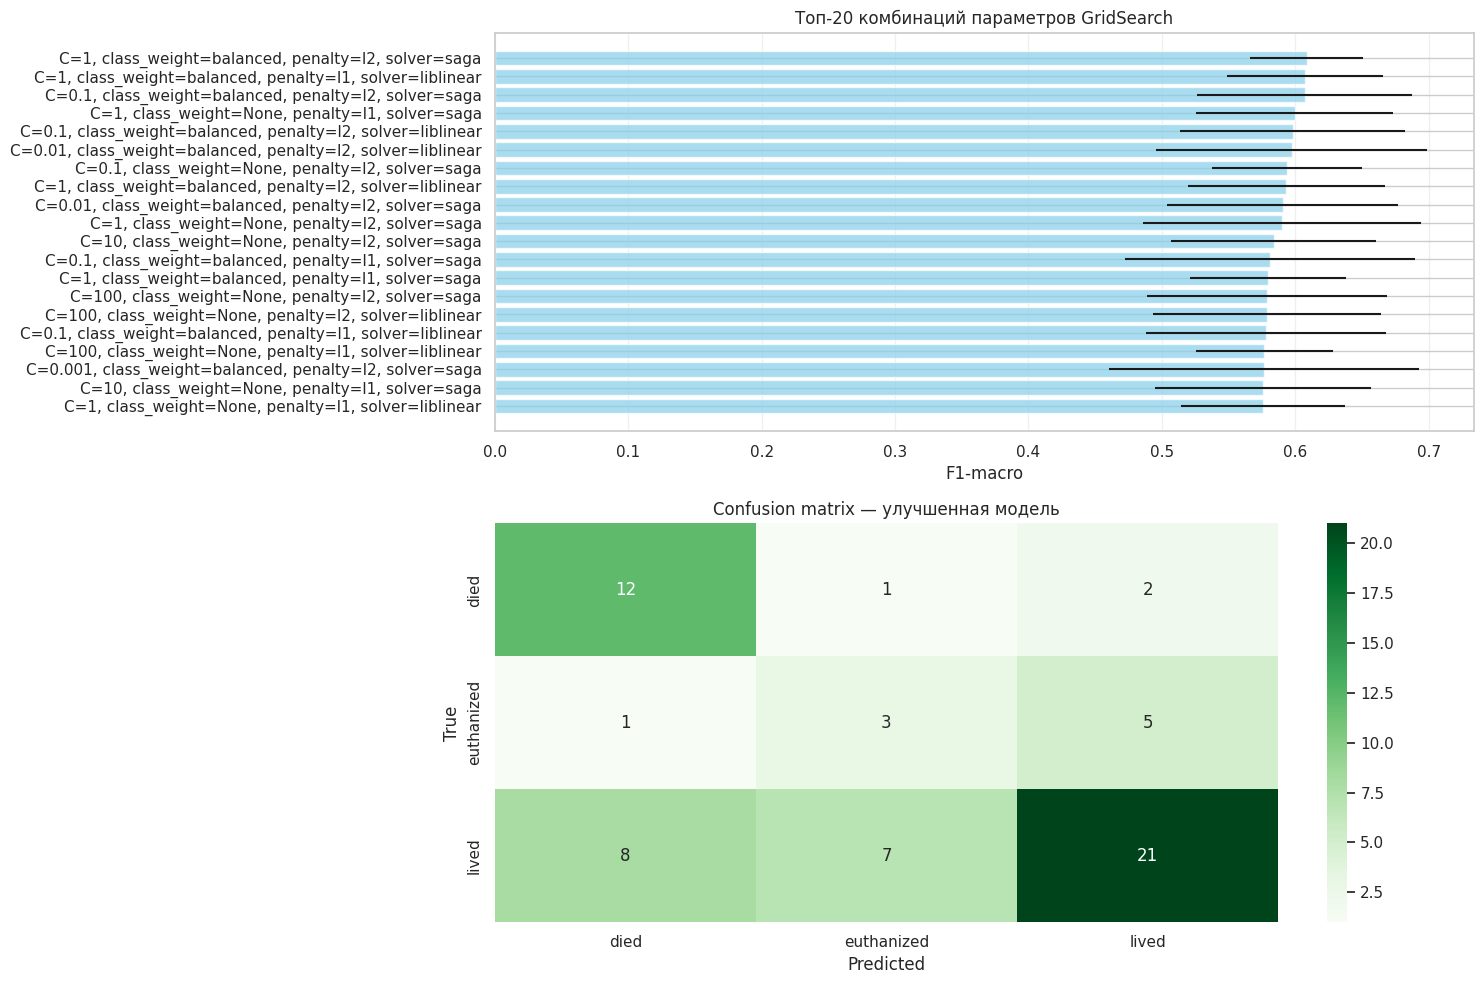


Результаты GridSearch:
   - Лучшая конфигурация: {'clf__C': 1, 'clf__class_weight': 'balanced', 'clf__penalty': 'l2', 'clf__solver': 'saga'}
   - Лучший F1-macro (CV): 0.6085

Производительность на тесте:
   - Accuracy: 0.6000
   - F1-macro: 0.5410

Улучшение по сравнению с бейзлайном:
   - Accuracy: +0.0%
   - F1-macro: +5.9%


In [44]:
fig, axes = plt.subplots(2, figsize=(15, 10))

cv_res_imp = pd.DataFrame(gs_imp.cv_results_)

top_results = cv_res_imp.nsmallest(20, "rank_test_score")[
    ["params", "mean_test_score", "std_test_score"]
].copy()


def params_to_str(params_dict):
    return ", ".join([f"{k.split('__')[-1]}={v}" for k, v in params_dict.items()])


top_results["params_str"] = top_results["params"].apply(params_to_str)

axes[0].barh(
    range(len(top_results)),
    top_results["mean_test_score"],
    xerr=top_results["std_test_score"],
    alpha=0.7,
    color="skyblue",
)
axes[0].set_yticks(range(len(top_results)))
axes[0].set_yticklabels(top_results["params_str"])
axes[0].set_xlabel("F1-macro")
axes[0].set_title("Топ-20 комбинаций параметров GridSearch")
axes[0].invert_yaxis()
axes[0].grid(True, alpha=0.3, axis="x")

cm_imp = confusion_matrix(y_test_imp, y_pred_imp, labels=best_model_imp.classes_)
sns.heatmap(
    cm_imp,
    annot=True,
    fmt="d",
    cmap="Greens",
    cbar=True,
    xticklabels=best_model_imp.classes_,
    yticklabels=best_model_imp.classes_,
    ax=axes[1],
)
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("True")
axes[1].set_title("Confusion matrix — улучшенная модель")

plt.tight_layout()
plt.show()


print("\nРезультаты GridSearch:")
print(f"   - Лучшая конфигурация: {gs_imp.best_params_}")
print(f"   - Лучший F1-macro (CV): {gs_imp.best_score_:.4f}")

print("\nПроизводительность на тесте:")
print(f"   - Accuracy: {acc_imp:.4f}")
print(f"   - F1-macro: {f1_imp:.4f}")

improvement_acc = (acc_imp - acc_base) / acc_base * 100
improvement_f1 = (f1_imp - f1_base) / f1_base * 100
print("\nУлучшение по сравнению с бейзлайном:")
print(f"   - Accuracy: +{improvement_acc:.1f}%")
print(f"   - F1-macro: +{improvement_f1:.1f}%")

## Собственная имплементация LogReg

In [45]:
class CustomLogReg(BaseEstimator, ClassifierMixin):
    def __init__(
        self,
        C=1.0,
        max_iter=100,
        penalty="l2",
        learning_rate=0.01,
        tol=1e-4,
        random_state=None,
    ):
        self.C = C
        self.max_iter = max_iter
        self.penalty = penalty
        self.learning_rate = learning_rate
        self.tol = tol
        self.random_state = random_state

    def fit(self, X, y):
        np.random.seed(self.random_state)

        X = np.asarray(X)
        y = np.asarray(y)

        self.classes_ = np.unique(y)
        self.n_classes_ = len(self.classes_)

        self.class_to_index_ = {cls: idx for idx, cls in enumerate(self.classes_)}

        y_encoded = np.zeros((len(y), self.n_classes_))
        for i, cls in enumerate(y):
            y_encoded[i, self.class_to_index_[cls]] = 1

        X_bias = np.hstack([np.ones((X.shape[0], 1)), X])

        self.weights_ = np.random.randn(X_bias.shape[1], self.n_classes_) * 0.01

        self.loss_history_ = []
        prev_loss = float("inf")

        for iteration in range(self.max_iter):
            logits = X_bias @ self.weights_
            probs = self._softmax(logits)

            loss = self._compute_loss(probs, y_encoded, X_bias)
            self.loss_history_.append(loss)

            if abs(prev_loss - loss) < self.tol:
                break
            prev_loss = loss

            grad = self._compute_gradient(X_bias, probs, y_encoded)

            self.weights_ -= self.learning_rate * grad

        return self

    def _softmax(self, z):
        z_stable = z - np.max(z, axis=1, keepdims=True)
        exp_z = np.exp(z_stable)
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def _sigmoid(self, z):
        return 1 / (1 + np.exp(-np.clip(z, -500, 500)))

    def _compute_loss(self, probs, y_true, X_bias):
        n_samples = X_bias.shape[0]

        epsilon = 1e-15
        probs_clipped = np.clip(probs, epsilon, 1 - epsilon)
        cross_entropy = -np.sum(y_true * np.log(probs_clipped)) / n_samples

        if self.penalty == "l2":
            reg_term = (1 / (2 * self.C)) * np.sum(self.weights_[1:] ** 2)
        elif self.penalty == "l1":
            reg_term = (1 / self.C) * np.sum(np.abs(self.weights_[1:]))
        else:
            reg_term = 0

        return cross_entropy + reg_term

    def _compute_gradient(self, X_bias, probs, y_true):
        n_samples = X_bias.shape[0]

        error = probs - y_true
        grad_ce = (X_bias.T @ error) / n_samples

        if self.penalty == "l2":
            reg_grad = np.zeros_like(self.weights_)
            reg_grad[1:] = (1 / self.C) * self.weights_[1:]
        elif self.penalty == "l1":
            reg_grad = np.zeros_like(self.weights_)
            reg_grad[1:] = (1 / self.C) * np.sign(self.weights_[1:])
        else:
            reg_grad = 0

        return grad_ce + reg_grad

    def predict_proba(self, X):
        X = np.asarray(X)
        X_bias = np.hstack([np.ones((X.shape[0], 1)), X])
        logits = X_bias @ self.weights_
        return self._softmax(logits)

    def predict(self, X):
        probas = self.predict_proba(X)
        indices = np.argmax(probas, axis=1)
        return self.classes_[indices]

    def score(self, X, y):
        y_pred = self.predict(X)
        return np.mean(y_pred == y)

Применяем собственный LogReg на исходных данных.


In [46]:
preprocess.fit(X_train)
X_train_base_t = preprocess.transform(X_train)
X_test_base_t = preprocess.transform(X_test)

log_reg_custom = CustomLogReg(C=1.0, max_iter=1000, random_state=42)
log_reg_custom.fit(X_train_base_t, y_train)
y_pred_custom = log_reg_custom.predict(X_test_base_t)


In [47]:
acc_custom = accuracy_score(y_test, y_pred_custom)
f1_custom = f1_score(y_test, y_pred_custom, average="macro")

print("Custom LogReg Accuracy (base data):", acc_custom)
print("Custom LogReg F1-macro (base data):", f1_custom)
print("\nClassification report:\n", classification_report(y_test, y_pred_custom))


Custom LogReg Accuracy (base data): 0.6166666666666667
Custom LogReg F1-macro (base data): 0.3684031324480763

Classification report:
               precision    recall  f1-score   support

        died       0.57      0.27      0.36        15
  euthanized       0.00      0.00      0.00         9
       lived       0.62      0.92      0.74        36

    accuracy                           0.62        60
   macro avg       0.40      0.39      0.37        60
weighted avg       0.52      0.62      0.54        60



/home/vitos/MAI/ml4/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/vitos/MAI/ml4/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/vitos/MAI/ml4/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.sh

Confusion matrtix для собственного бейзлайна

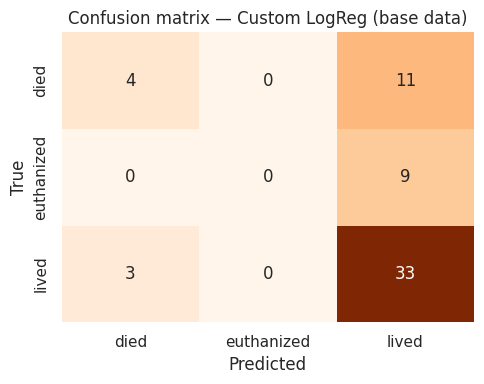

In [48]:
cm_custom = confusion_matrix(y_test, y_pred_custom, labels=model_base.classes_)
fig, ax = plt.subplots(figsize=(5, 4))
sns.heatmap(
    cm_custom,
    annot=True,
    fmt="d",
    cmap="Oranges",
    cbar=False,
    xticklabels=model_base.classes_,
    yticklabels=model_base.classes_,
    ax=ax,
)
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title("Confusion matrix — Custom LogReg (base data)")
plt.tight_layout()
plt.show()


Custom LogReg на улучшенных данных (используем лучшие параметры из GridSearch).

In [49]:
preprocess_imp.fit(X_train_imp)
X_train_imp_t = preprocess_imp.transform(X_train_imp)
X_test_imp_t = preprocess_imp.transform(X_test_imp)

best_C = gs_imp.best_params_.get("clf__C", 1.0)
best_penalty = gs_imp.best_params_.get("clf__penalty", "l2")


custom_logreg_imp = CustomLogReg(
    C=best_C, penalty=best_penalty, max_iter=2000, random_state=12
)
custom_logreg_imp.fit(X_train_imp_t, y_train_imp)
y_pred_custom_imp = custom_logreg_imp.predict(X_test_imp_t)

acc_custom_imp = accuracy_score(y_test_imp, y_pred_custom_imp)
f1_custom_imp = f1_score(y_test_imp, y_pred_custom_imp, average="macro")

print("Custom LogReg (improved) Accuracy:", acc_custom_imp)
print("Custom LogReg (improved) F1-macro:", f1_custom_imp)

Custom LogReg (improved) Accuracy: 0.6166666666666667
Custom LogReg (improved) F1-macro: 0.38409961685823757


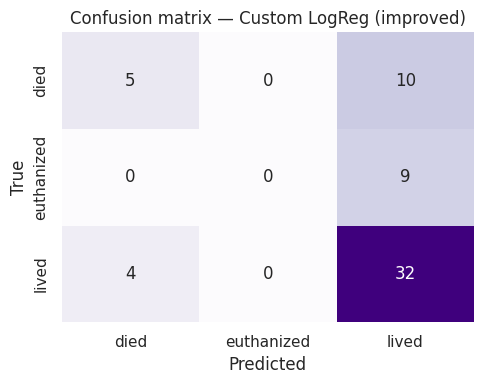

In [50]:
cm_custom_imp = confusion_matrix(y_test_imp, y_pred_custom_imp, labels=gs_imp.classes_)
fig, ax = plt.subplots(figsize=(5, 4))
sns.heatmap(
    cm_custom_imp,
    annot=True,
    fmt="d",
    cmap="Purples",
    cbar=False,
    xticklabels=gs_imp.classes_,
    yticklabels=gs_imp.classes_,
    ax=ax,
)
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title("Confusion matrix — Custom LogReg (improved)")
plt.tight_layout()
plt.show()

In [51]:
summary_base = pd.DataFrame(
    {
        "model": ["Бейзлайн (sklearn LogReg)", "Custom LogReg (base data)"],
        "accuracy": [acc_base, acc_custom],
        "f1_macro": [f1_base, f1_custom],
    }
)
print("Сравнение с бейзлайном:\n", summary_base, sep="")

summary_improved = pd.DataFrame(
    {
        "model": ["Улучшенный бейзлайн", "Custom LogReg (improved)"],
        "accuracy": [acc_imp, acc_custom_imp],
        "f1_macro": [f1_imp, f1_custom_imp],
    }
)
print("\nСравнение с улучшенными данными:\n", summary_improved, sep="")

summary_all = pd.DataFrame(
    {
        "model": [
            "Бейзлайн (sklearn LogReg)",
            "Custom LogReg (base data)",
            "Улучшенный бейзлайн",
            "Custom LogReg (improved)",
        ],
        "accuracy": [acc_base, acc_custom, acc_imp, acc_custom_imp],
        "f1_macro": [f1_base, f1_custom, f1_imp, f1_custom_imp],
    }
)
print("\nВсе модели:\n", summary_all, sep="")

Сравнение с бейзлайном:
                       model  accuracy  f1_macro
0  Бейзлайн (sklearn LogReg)  0.600000  0.510979
1  Custom LogReg (base data)  0.616667  0.368403

Сравнение с улучшенными данными:
                      model  accuracy  f1_macro
0       Улучшенный бейзлайн  0.600000  0.540972
1  Custom LogReg (improved)  0.616667  0.384100

Все модели:
                       model  accuracy  f1_macro
0  Бейзлайн (sklearn LogReg)  0.600000  0.510979
1  Custom LogReg (base data)  0.616667  0.368403
2        Улучшенный бейзлайн  0.600000  0.540972
3   Custom LogReg (improved)  0.616667  0.384100


## Выводы

Основные результаты:
```
Модель	Accuracy	F1-macro	Статус
Бейзлайн sklearn	0.600	0.511	Эталон
Custom LogReg (база)	0.617	0.368	↑Accuracy, ↓F1
Улучшенный sklearn	0.600	0.541	Лучший F1
Custom LogReg (улучш.)	0.617	0.384	↑Accuracy, ↓F1
```
Ключевые выводы:
1. Sklearn vs Custom:
   - Custom модель: Лучше по Accuracy (+2.8%)
   - Sklearn модель: Значительно лучше по F1-macro (+37% относительно кастомной)

2. GridSearch эффективность:
   - Улучшил F1-macro sklearn модели на 5.9% (0.511 → 0.541)
   - На кастомной модели улучшение меньше (+4.3%)

3. Дисбаланс классов:
   - Высокий Accuracy, низкий F1 у кастомной модели → переобучение на доминирующий класс
   - Sklearn лучше справляется с многоклассовым дисбалансом

# Регрессия с помощью модели линейной регрессии

In [52]:
path_reg = "dataset/Employee_Complete_Dataset.csv"
reg_df = pd.read_csv(path_reg)
print(reg_df.shape)
reg_df.head()

(50000, 19)


,Employee_number,Employee_name,Employee_age,Maritial_Status,Current_Salary,Number_of_Children,years_experience,past_projects,current_projects,Divorced_earlier,Father_alive,Mother_alive,performance_rating,Education_level,Department,Role,Job_Satisfaction,Work_Life_Balance,is_outlier
0,10001,Karen Anderson,36,True,116138,2,12,6,1,No,Yes,Yes,3,Bachelor's,R&D,Researcher,10.000000,1.936454,0
1,10002,David Taylor,34,False,82171,3,10,5,0,Yes,Yes,No,5,Diploma,HR,HR Executive,10.000000,4.077728,0
2,10003,Nina Kumar,36,False,48600,1,0,2,3,Yes,Yes,Yes,4,Diploma,Sales,Sales Manager,10.000000,3.975622,0
3,10004,John Patel,42,True,39675,1,2,4,2,Yes,Yes,Yes,3,Diploma,Engineering,Software Engineer,1.000000,3.790951,0
4,10005,Emily Sharma,27,True,161304,3,3,11,2,Yes,Yes,Yes,2,High School,R&D,Scientist,8.251833,10.000000,0


## Бейзлайн

Заведем датасет для бейзлайн модели

In [53]:
df_base = reg_df.copy()

X_base = df_base.drop(
    columns=[
        "Current_Salary",
        "Employee_number",
        "Employee_name",
        "is_outlier",
        "Divorced_earlier",
        "Father_alive",
        "Mother_alive",
        "Maritial_Status",
        "Role",
        "Education_level",
        "Department",
    ]
)
y_base = df_base["Current_Salary"]

X_train_base, X_test_base, y_train_base, y_test_base = train_test_split(
    X_base, y_base, test_size=0.2, random_state=52
)

## Бейзлайн модель

In [54]:
model = LinearRegression()
model.fit(X_train_base, y_train_base)

y_pred_base = model.predict(X_test_base)

base_mae = mean_absolute_error(y_test_base, y_pred_base)
base_rmse = np.sqrt(mean_squared_error(y_test_base, y_pred_base))
base_r2 = r2_score(y_test_base, y_pred_base)

print(f"MAE: {base_mae:.2f}")
print(f"RMSE: {base_rmse:.2f}")
print(f"R2: {base_r2:.4f}")
print(f"Количество признаков: {X.shape[1]}")
print(f"Размер обучающей выборки: {X_train.shape[0]}")
print(f"Размер тестовой выборки: {X_test.shape[0]}")

MAE: 19242.83
RMSE: 28666.47
R2: 0.1285
Количество признаков: 27
Размер обучающей выборки: 239
Размер тестовой выборки: 60


## Улучшенная модель:
- с подбором гиперпараметров
- с регуляризацией

Заведем почищенный датасет

In [55]:
numeric_features = [
    "Employee_age",
    "Number_of_Children",
    "years_experience",
    "past_projects",
    "current_projects",
    "performance_rating",
    "Job_Satisfaction",
    "Work_Life_Balance",
]
categorical_features = [
    "Education_level",
    "Department",
    "Role",
]
binary_features = [
    "Maritial_Status",
    "Divorced_earlier",
    "Father_alive",
    "Mother_alive",
]

df_imp = reg_df.copy()

df_imp = df_imp.drop(["Employee_number", "Employee_name", "is_outlier"], axis=1)

for col in binary_features:
    df_imp[col] = df_imp[col].map(
        {
            "Yes": True,
            "No": False,
            "True": True,
            "False": False,
            True: True,
            False: False,
        }
    )

y_imp = df_imp["Current_Salary"]
X_imp = df_imp.drop("Current_Salary", axis=1)

X_train_imp, X_test_imp, y_train_imp, y_test_imp = train_test_split(
    X_imp, y_imp, test_size=0.2, random_state=42
)

Натренируем модель 

In [56]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        (
            "cat",
            OneHotEncoder(handle_unknown="error", sparse_output=True),
            categorical_features,
        ),
        ("binary", "passthrough", binary_features),
    ]
)

pipeline = Pipeline(
    [("preprocessor", preprocessor), ("regressor", ElasticNet(max_iter=10000))]
)

param_grid = {
    "regressor__alpha": [0.001, 0.01, 0.1, 1.0, 10.0],
    "regressor__l1_ratio": [0.1, 0.3, 0.7, 0.9],
    "regressor__fit_intercept": [True, False],
}

gs_imp = GridSearchCV(pipeline, param_grid, cv=3, scoring="r2", n_jobs=-1, verbose=1)

gs_imp.fit(X_train_imp, y_train_imp)

print(f"\nЛучшие параметры: {gs_imp.best_params_}")
print(f"Лучший R2 на кросс-валидации: {gs_imp.best_score_:.4f}")

best_model = gs_imp.best_estimator_
y_pred_imp = best_model.predict(X_test_imp)

imp_mae = mean_absolute_error(y_test_imp, y_pred_imp)
imp_rmse = np.sqrt(mean_squared_error(y_test_imp, y_pred_imp))
imp_r2 = r2_score(y_test_imp, y_pred_imp)

print("\nРезультаты на тестовой выборке:")
print(f"MAE: {imp_mae:.2f}")
print(f"RMSE: {imp_rmse:.2f}")
print(f"R2: {imp_r2:.4f}")
print(f"Количество признаков: {X_imp.shape[1]}")
print(f"Размер тестовой выборки: {X_test_imp.shape[0]}")

numeric_feature_names = numeric_features
cat_encoder = best_model.named_steps["preprocessor"].named_transformers_["cat"]
if hasattr(cat_encoder, "get_feature_names_out"):
    cat_feature_names = cat_encoder.get_feature_names_out(categorical_features).tolist()
else:
    cat_feature_names = []

all_feature_names = numeric_feature_names + cat_feature_names

print("\nТоп-10 самых важных признаков (по абсолютному значению коэффициента):")
if hasattr(best_model.named_steps["regressor"], "coef_"):
    coef = best_model.named_steps["regressor"].coef_

    preprocessor = best_model.named_steps["preprocessor"]
    feature_names = []

    feature_names.extend(numeric_features)

    cat_encoder = preprocessor.named_transformers_["cat"]
    if hasattr(cat_encoder, "get_feature_names_out"):
        cat_feature_names = cat_encoder.get_feature_names_out(categorical_features)
        feature_names.extend(cat_feature_names)

    coef_df = pd.DataFrame(
        {
            "feature": feature_names[: len(coef)],
            "coefficient": coef[: len(feature_names)],
        }
    ).sort_values("coefficient", key=abs, ascending=False)

    print(coef_df.head(10).to_string())


Fitting 3 folds for each of 40 candidates, totalling 120 fits

Лучшие параметры: {'regressor__alpha': 0.1, 'regressor__fit_intercept': True, 'regressor__l1_ratio': 0.7}
Лучший R2 на кросс-валидации: 0.1182

Результаты на тестовой выборке:
MAE: 19696.67
RMSE: 31126.94
R2: 0.1056
Количество признаков: 15
Размер тестовой выборки: 10000

Топ-10 самых важных признаков (по абсолютному значению коэффициента):
                     feature  coefficient
6           Job_Satisfaction  9897.209449
7          Work_Life_Balance  2452.440818
0               Employee_age  2217.372343
28          Role_Ops Manager  -658.796654
12       Education_level_PhD  -495.957702
14        Department_Finance  -488.691978
16     Department_Operations  -446.874739
15             Department_HR   442.528132
24         Role_HR Executive   435.612598
11  Education_level_Master's   405.501753


## Моя реализация линейной регрессии

In [57]:
class MyLinearRegression:
    def __init__(self, fit_intercept=True):
        self.fit_intercept = fit_intercept
        self.coef_ = None
        self.intercept_ = None
        self.n_features_in_ = None

    def fit(self, X, y):
        X = np.array(X, dtype=np.float64)
        y = np.array(y, dtype=np.float64)

        if X.ndim == 1:
            X = X.reshape(-1, 1)

        if len(X) != len(y):
            raise ValueError(
                f"X и y должны иметь одинаковую длину: {len(X)} != {len(y)}"
            )

        n_samples, n_features = X.shape
        self.n_features_in_ = n_features

        if self.fit_intercept:
            X_design = np.column_stack([np.ones(n_samples), X])
        else:
            X_design = X

        try:
            XTX = X_design.T @ X_design
            XTX_inv = np.linalg.pinv(XTX)
            weights = XTX_inv @ X_design.T @ y

            if self.fit_intercept:
                self.intercept_ = weights[0]
                self.coef_ = weights[1:]
            else:
                self.intercept_ = 0.0
                self.coef_ = weights

        except np.linalg.LinAlgError:
            self._gradient_descent_fit(X, y)

        return self

    def _gradient_descent_fit(self, X, y, learning_rate=0.01, n_iterations=1000):
        n_samples, n_features = X.shape

        if self.fit_intercept:
            X_design = np.column_stack([np.ones(n_samples), X])
            weights = np.zeros(n_features + 1)
        else:
            X_design = X
            weights = np.zeros(n_features)

        for i in range(n_iterations):
            y_pred = X_design @ weights
            error = y_pred - y
            gradient = (2 / n_samples) * (X_design.T @ error)
            weights -= learning_rate * gradient

        if self.fit_intercept:
            self.intercept_ = weights[0]
            self.coef_ = weights[1:]
        else:
            self.intercept_ = 0.0
            self.coef_ = weights

    def predict(self, X):
        if self.coef_ is None:
            raise ValueError("Модель еще не обучена. Вызовите fit() перед predict().")

        X = np.array(X, dtype=np.float64)

        if X.ndim == 1:
            X = X.reshape(-1, 1)

        if X.shape[1] != len(self.coef_):
            raise ValueError(
                f"Количество признаков должно быть {len(self.coef_)}, "
                f"получено {X.shape[1]}"
            )

        y_pred = X @ self.coef_ + self.intercept_

        return y_pred

    def score(self, X, y):
        y = np.array(y, dtype=np.float64)
        y_pred = self.predict(X)

        ss_res = np.sum((y - y_pred) ** 2)
        ss_tot = np.sum((y - np.mean(y)) ** 2)

        if ss_tot == 0:
            return 1.0 if ss_res == 0 else 0.0

        r2 = 1 - (ss_res / ss_tot)
        return r2

    def get_params(self, deep=False):
        return {"fit_intercept": self.fit_intercept}

    def set_params(self, **params):
        for key, value in params.items():
            setattr(self, key, value)
        return self

    def __repr__(self):
        return f"MyLinearRegression(fit_intercept={self.fit_intercept})"

Обучаем на неподготовленных данных

In [58]:
model = MyLinearRegression()
model.fit(X_train_base, y_train_base)

y_pred_my_base = model.predict(X_test_base)

my_base_mae = mean_absolute_error(y_test_base, y_pred_my_base)
my_base_rmse = np.sqrt(mean_squared_error(y_test_base, y_pred_my_base))
my_base_r2 = r2_score(y_test_base, y_pred_my_base)

print(f"MAE: {my_base_mae:.2f}")
print(f"RMSE: {my_base_rmse:.2f}")
print(f"R2: {my_base_r2:.4f}")
print(f"Количество признаков: {X_imp.shape[1]}")
print(f"Размер обучающей выборки: {X_train_base.shape[0]}")
print(f"Размер тестовой выборки: {X_test_base.shape[0]}")

MAE: 19242.83
RMSE: 28666.47
R2: 0.1285
Количество признаков: 15
Размер обучающей выборки: 40000
Размер тестовой выборки: 10000


Теперь на подготовленных c грид серчем

In [59]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        (
            "cat",
            OneHotEncoder(handle_unknown="error", sparse_output=False),
            categorical_features,
        ),
        ("binary", "passthrough", binary_features),
    ]
)

pipeline = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("regressor", MyLinearRegression()),
    ]
)

param_grid = {
    "regressor__fit_intercept": [True, False],
}

gs_my_imp = GridSearchCV(
    pipeline, param_grid, cv=10, scoring="r2", n_jobs=-1, verbose=1
)

gs_my_imp.fit(X_train_imp, y_train_imp)

print(f"\nЛучшие параметры: {gs_my_imp.best_params_}")
print(f"Лучший R2 на кросс-валидации: {gs_my_imp.best_score_:.4f}")

best_model = gs_my_imp.best_estimator_
y_pred_my_imp = best_model.predict(X_test_imp)

my_imp_mae = mean_absolute_error(y_test_imp, y_pred_my_imp)
my_imp_rmse = np.sqrt(mean_squared_error(y_test_imp, y_pred_my_imp))
my_imp_r2 = r2_score(y_test_imp, y_pred_my_imp)

print("\nРезультаты на тестовой выборке:")
print(f"MAE: {my_imp_mae:.2f}")
print(f"RMSE: {my_imp_rmse:.2f}")
print(f"R2: {my_imp_r2:.4f}")
print(f"Количество признаков: {X_imp.shape[1]}")
print(f"Размер тестовой выборки: {X_test_imp.shape[0]}")

numeric_feature_names = numeric_features
cat_encoder = best_model.named_steps["preprocessor"].named_transformers_["cat"]
if hasattr(cat_encoder, "get_feature_names_out"):
    cat_feature_names = cat_encoder.get_feature_names_out(categorical_features).tolist()
else:
    cat_feature_names = []

all_feature_names = numeric_feature_names + cat_feature_names

print("\nКоэффициенты модели (топ-10):")
if hasattr(best_model.named_steps["regressor"], "coef_"):
    coef = best_model.named_steps["regressor"].coef_
    preprocessor = best_model.named_steps["preprocessor"]

    feature_names = []

    feature_names.extend(numeric_features)

    cat_encoder = preprocessor.named_transformers_["cat"]
    if hasattr(cat_encoder, "get_feature_names_out"):
        cat_feature_names = cat_encoder.get_feature_names_out(categorical_features)
        feature_names.extend(cat_feature_names)

    coef_df = pd.DataFrame(
        {
            "feature": feature_names[: len(coef)],
            "coefficient": coef[: len(feature_names)],
        }
    ).sort_values("coefficient", key=abs, ascending=False)

    print(coef_df.head(10).to_string())

Fitting 10 folds for each of 2 candidates, totalling 20 fits

Лучшие параметры: {'regressor__fit_intercept': False}
Лучший R2 на кросс-валидации: 0.1194

Результаты на тестовой выборке:
MAE: 19677.60
RMSE: 31130.99
R2: 0.1054
Количество признаков: 15
Размер тестовой выборки: 10000

Коэффициенты модели (топ-10):
                        feature   coefficient
11     Education_level_Master's  28447.884401
8    Education_level_Bachelor's  28167.189131
10  Education_level_High School  28064.809017
9       Education_level_Diploma  27801.420825
12          Education_level_PhD  26699.116762
13       Department_Engineering  22188.544961
15                Department_HR  20039.116430
18             Department_Sales  19714.585122
19           Department_Support  19679.235548
17               Department_R&D  19553.605791


+----------------------+----------+----------+--------+-----------------+------------------+----------------+
| Модель               |      MAE |     RMSE |     R2 |   ΔMAE (к базе) |   ΔRMSE (к базе) |   ΔR2 (к базе) |
+======================+==========+==========+========+=================+==================+================+
| Базовая (наша)       | 19242.83 | 28666.47 | 0.1285 |           -0.00 |            -0.00 |         0.0000 |
+----------------------+----------+----------+--------+-----------------+------------------+----------------+
| Базовая (sklearn)    | 19242.83 | 28666.47 | 0.1285 |            0.00 |             0.00 |         0.0000 |
+----------------------+----------+----------+--------+-----------------+------------------+----------------+
| Улучшенная (sklearn) | 19696.67 | 31126.94 | 0.1056 |          453.85 |          2460.47 |        -0.0229 |
+----------------------+----------+----------+--------+-----------------+------------------+----------------+
| Улучшенн

/tmp/ipykernel_1793768/2708247679.py:84: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(models, rotation=45, ha="right")


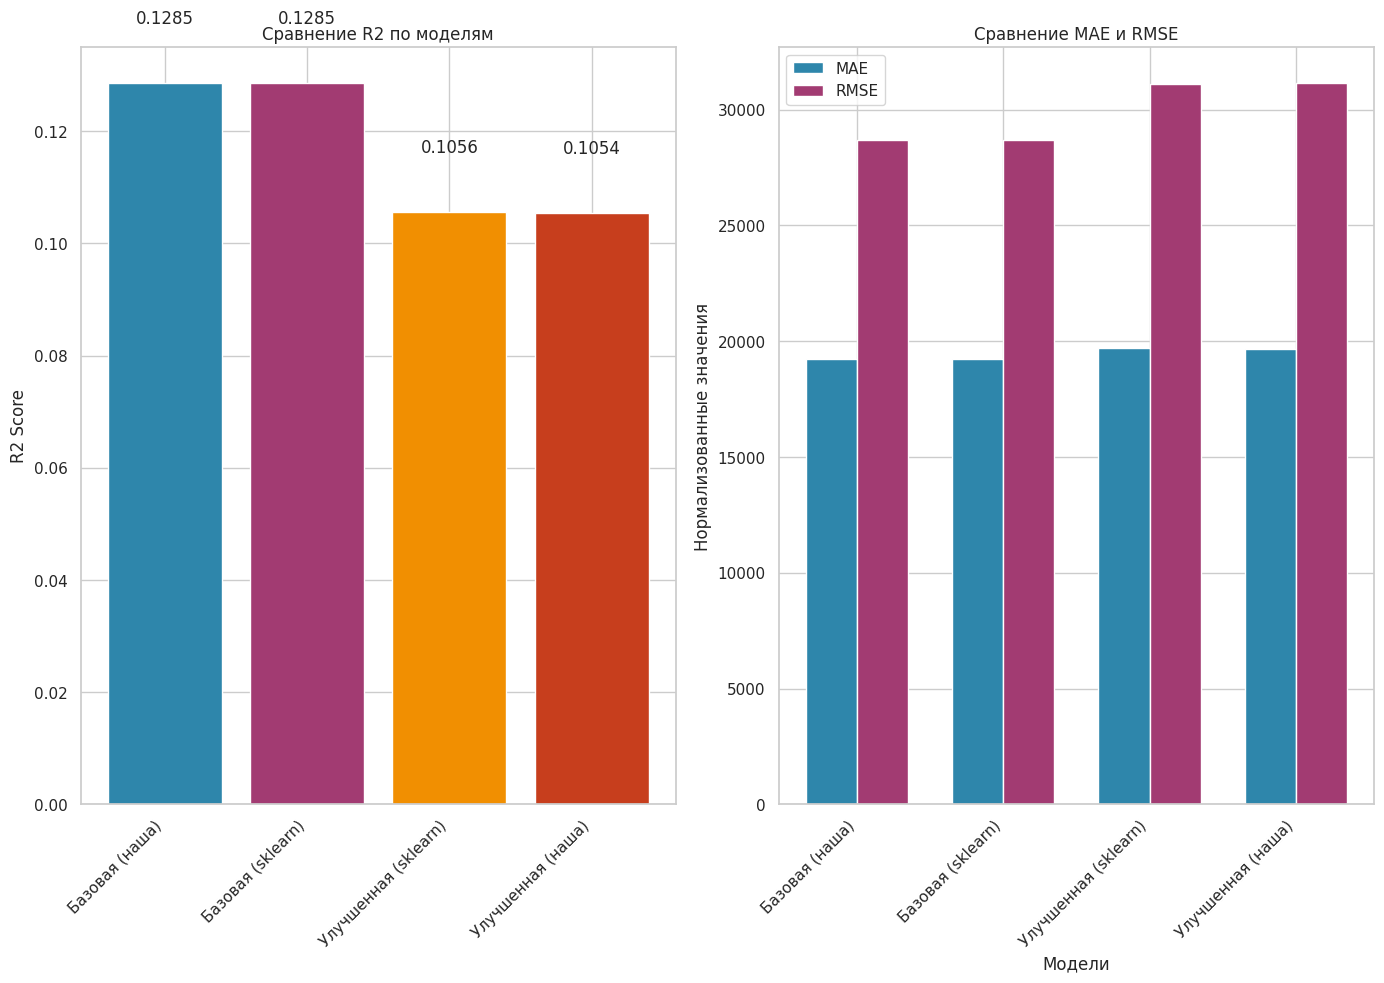

In [60]:
from tabulate import tabulate

comparison_data = {
    "Модель": [
        "Базовая (sklearn)",
        "Улучшенная (sklearn)",
        "Базовая (наша)",
        "Улучшенная (наша)",
    ],
    "MAE": [base_mae, imp_mae, my_base_mae, my_imp_mae],
    "RMSE": [base_rmse, imp_rmse, my_base_rmse, my_imp_rmse],
    "R2": [base_r2, imp_r2, my_base_r2, my_imp_r2],
}

df_comparison = pd.DataFrame(comparison_data)

df_comparison["ΔMAE (к базе)"] = df_comparison["MAE"] - base_mae
df_comparison["ΔRMSE (к базе)"] = df_comparison["RMSE"] - base_rmse
df_comparison["ΔR2 (к базе)"] = df_comparison["R2"] - base_r2

df_comparison = df_comparison.sort_values("R2", ascending=False)

print(
    tabulate(
        df_comparison,
        headers="keys",
        tablefmt="grid",
        floatfmt=(".0f", ".2f", ".2f", ".4f", ".2f", ".2f", ".4f"),
        showindex=False,
    )
)

best_model = df_comparison.iloc[0]
worst_model = df_comparison.iloc[-1]

print(f"1. Лучшая модель: {best_model['Модель']}")
print(f"   - R2: {best_model['R2']:.4f}")
print(f"   - Улучшение R2 относительно базовой: {best_model['ΔR2 (к базе)']:.4f}")

print(f"\n2. Худшая модель: {worst_model['Модель']}")
print(f"   - R2: {worst_model['R2']:.4f}")
print(f"   - Просадка R2 относительно базовой: {worst_model['ΔR2 (к базе)']:.4f}")

print("\n3. Сравнение моей реализации со sklearn:")
for i, row in df_comparison.iterrows():
    if "наша" in row["Модель"]:
        corresponding_sklearn = (
            row["Модель"].replace("наша", "sklearn").replace("(наша)", "(sklearn)")
        )
        sklearn_row = df_comparison[df_comparison["Модель"] == corresponding_sklearn]
        if not sklearn_row.empty:
            sklearn_r2 = sklearn_row.iloc[0]["R2"]
            diff = row["R2"] - sklearn_r2
            print(
                f"   {row['Модель']}: R2 = {row['R2']:.4f}, разница со sklearn: {diff:+.4f}"
            )

print("\n4. Эффективность улучшений:")
improvement_base_to_imp = (
    df_comparison[df_comparison["Модель"] == "Улучшенная (sklearn)"]["R2"].values[0]
    - base_r2
)
improvement_my_base_to_my_imp = (
    df_comparison[df_comparison["Модель"] == "Улучшенная (наша)"]["R2"].values[0]
    - my_base_r2
)

print(
    f"   - Улучшение sklearn моделей (базовая → улучшенная): {improvement_base_to_imp:+.4f}"
)
print(
    f"   - Улучшение наших моделей (базовая → улучшенная): {improvement_my_base_to_my_imp:+.4f}"
)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 10))

models = df_comparison["Модель"]
r2_scores = df_comparison["R2"]

colors = ["#2E86AB", "#A23B72", "#F18F01", "#C73E1D"]
bars = ax1.bar(models, r2_scores, color=colors)
ax1.set_ylabel("R2 Score")
ax1.set_title("Сравнение R2 по моделям")
ax1.set_xticklabels(models, rotation=45, ha="right")

for bar, score in zip(bars, r2_scores):
    height = bar.get_height()
    ax1.text(
        bar.get_x() + bar.get_width() / 2.0,
        height + 0.01,
        f"{score:.4f}",
        ha="center",
        va="bottom",
    )

x = np.arange(len(models))
width = 0.35

ax2.bar(x - width / 2, df_comparison["MAE"], width, label="MAE", color="#2E86AB")
ax2.bar(x + width / 2, df_comparison["RMSE"], width, label="RMSE", color="#A23B72")
ax2.set_xlabel("Модели")
ax2.set_ylabel("Нормализованные значения")
ax2.set_title("Сравнение MAE и RMSE")
ax2.set_xticks(x)
ax2.set_xticklabels(models, rotation=45, ha="right")
ax2.legend()

plt.tight_layout()
plt.show()


## Вывод

Получилось так, что дополнительные колонки негативно повлияли на результаты моделей, хоть и использовалась регуляризация